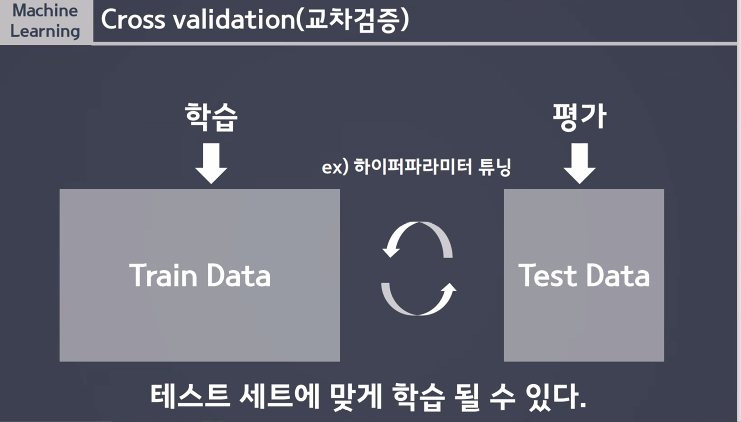
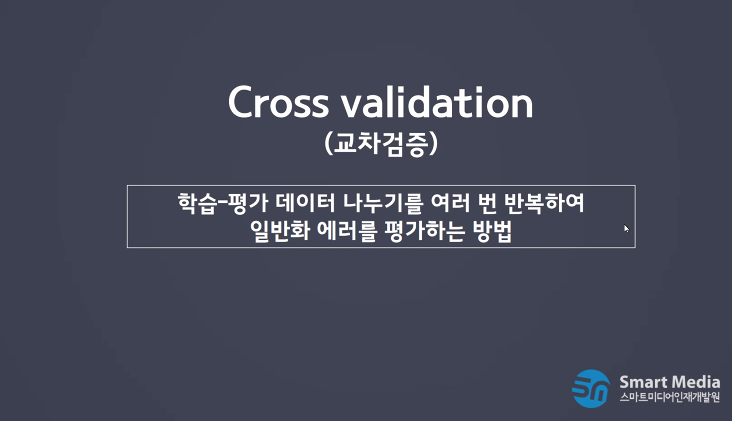
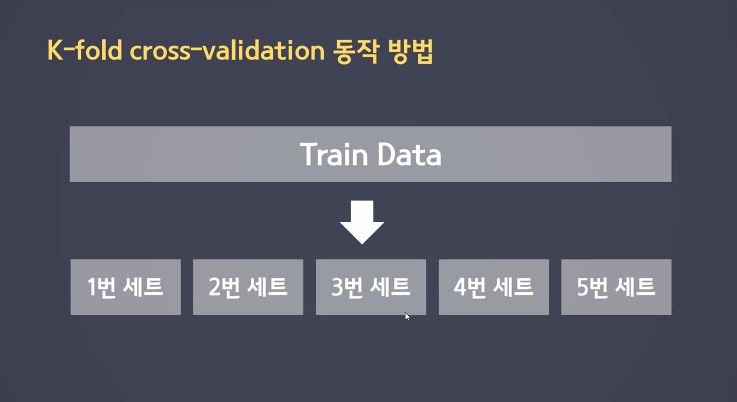
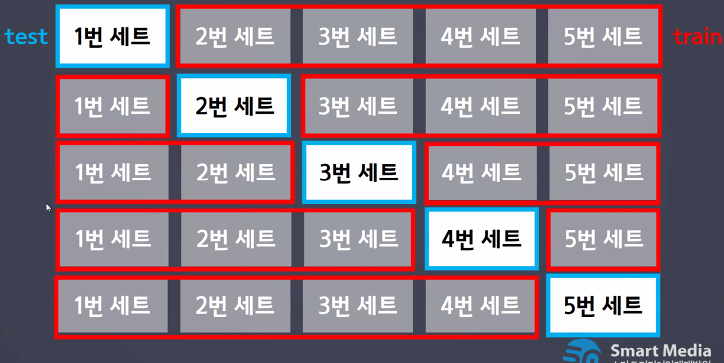
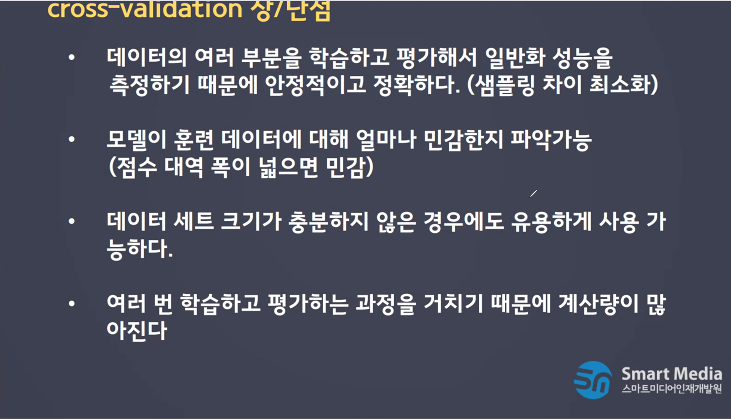

#### 목표
- 일반화 성능을 좀 더 정확히 판단하기 위한 교차 검증을 이해
- 모델의 성능을 향상 시켜주는 기법인 앙상블을 이해

In [1]:
# 교차 검증 사용
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pylab as plt # 파이썬 시각화 도구
import numpy as np

In [2]:
# 데이터 전 처리
house_data = pd.read_csv("./data/melb_data.csv")

In [3]:
# 결측치 처리
house_median = house_data['Car'].median()
house_data['Car'].fillna(house_median, inplace =True)
house_data['BuildingArea'].fillna(126,inplace=True)
house_data['YearBuilt'].fillna(1970, inplace=True)
house_data['CouncilArea'].fillna('Moreland', inplace=True)

In [4]:
# 인코딩
type_one_hot = pd.get_dummies(house_data['Type'],prefix='Type')
house_data = pd.concat([house_data,type_one_hot],axis=1)
CouncilArea_ont_hot = pd.get_dummies(house_data['CouncilArea'],prefix='CouncilArea')
house_data = pd.concat([house_data,CouncilArea_ont_hot],axis=1)

In [5]:
# Car, BuildingArea, YearBuilt, Type_h, Type_u, Type_t 추가해서 학습하기
X=house_data[["Rooms","Bathroom","Landsize","Lattitude","Longtitude",
             "Car", "BuildingArea", "YearBuilt", "Type_h", "Type_u", "Type_t"]]
y=house_data["Price"]

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1201)

In [7]:
house_model = DecisionTreeRegressor(random_state=1)

In [8]:
cross_val_score(house_model, X_train,y_train,cv=5,scoring='neg_mean_absolute_error').mean()

-238815.75444280804

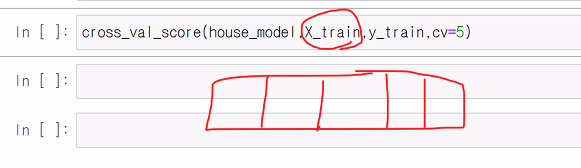

#### 교차검증을 적용한 하이퍼파라미터  

In [9]:
train_score = [] # 복잡도 변화에 따른 훈련용 데이터 평가 결과
test_score = [] # 복잡도 변화에 따른 평가용 데이터 평가 결과
for depth in range(1,50) :
    m = DecisionTreeRegressor(random_state=1, max_depth=depth)
    m.fit(X_train,y_train)
    # 훈련용 데이터 예측 및 평가
    train_pre = m.predict(X_train) # 훈련용 데이터 예측
    train_mae = mean_absolute_error(train_pre, y_train) # 훈련용 데이터 평가
    train_score.append(train_mae) # 오차를 리스트에 추가
    # 테스트 데이터 예측 및 평가
    cross_score = cross_val_score(m,X_train,y_train,cv=5,scoring="neg_mean_absolute_error")
    test_score.append(np.abs(cross_score.mean()))

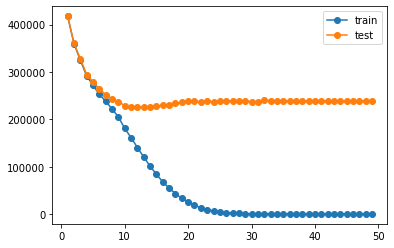

In [10]:
plt.plot(range(1,50),train_score, marker="o", label='train') # 선그래프
plt.plot(range(1,50),test_score, marker="o", label='test')
plt.legend() # 범

#### 앙상블
- 단일 모델의 예측 성능의 한계를 넘기 위해서 여러 모델의 의견을 종합하는 앙상블 개념 등장
- Voting : 여러 의견을 내는 다양한 알고리즘의 모델을 만들고 투표를 통해서 예측하는 기법
- Bagging(RandomForest) : 동일한 알고리즘의 모델을 여러개 만들어서 투표하는 기법
    - 사용하는 row 데이터를 다르게
    - 사용하는 column을 다르게
- Boosting(GradientBoosting) :  동일한 알고리즘의 모델을 여러개 만들어서 투표하는 기법
    - 이전 모델의 오차를 다음 모델에 반영해서 개선하는 기법

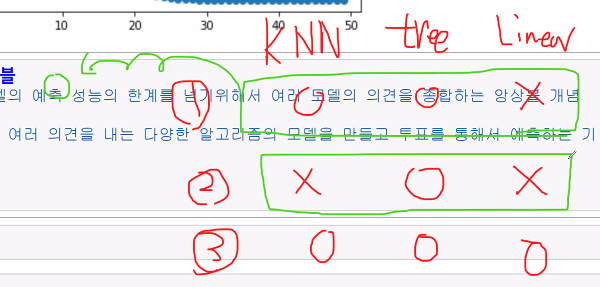
Voting
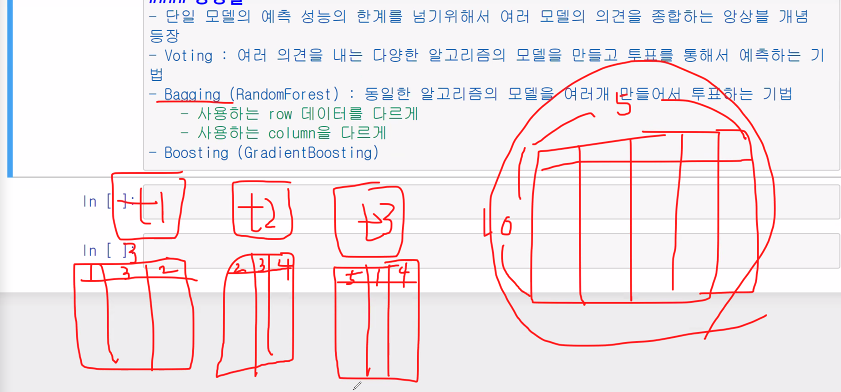
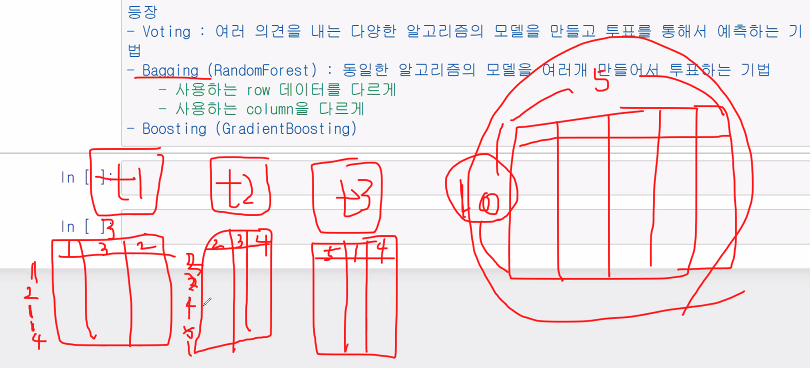
Bagging - 랜덤하게 3개 뽑아 트리별?
랜덤하게 추출하지만 랜덤하게 뽑아
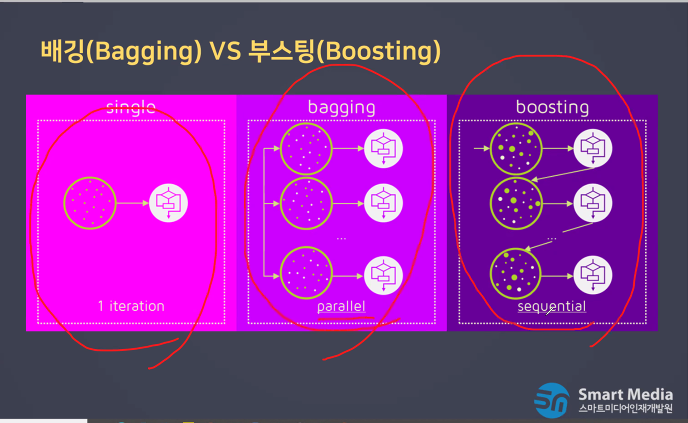

In [11]:
#랜덤포레스트 사용하기
from sklearn.ensemble import RandomForestRegressor

In [12]:
rf_dodel = RandomForestRegressor(random_state=1, n_estimators=500, max_depth=5)

In [13]:
cross_val_score(rf_dodel,X_train,y_train,cv=5,scoring='neg_mean_absolute_error')

array([-253871.7230262 , -248736.08989502, -262115.94719088,
       -257196.04333657, -260732.95020837])

In [14]:
# 그라디언트부스팅 사용하기
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
gb_model = GradientBoostingRegressor(n_estimators=500,learning_rate=0.01, max_depth=5)

In [16]:
cross_val_score(gb_model,X_train,y_train,cv=5,scoring='neg_mean_absolute_error')

array([-185071.31626842, -185809.23695697, -187070.59916429,
       -189216.75111656, -191642.44793001])

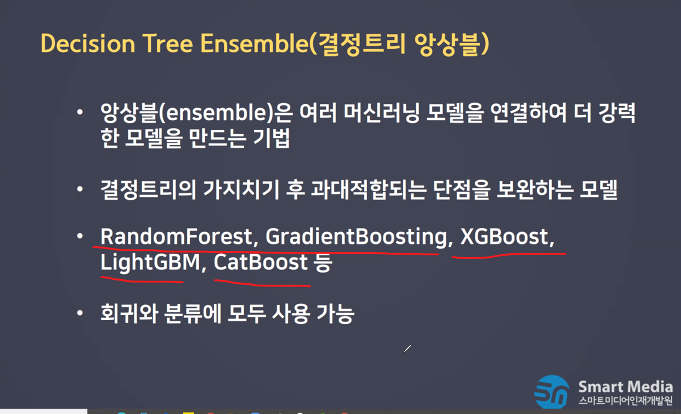
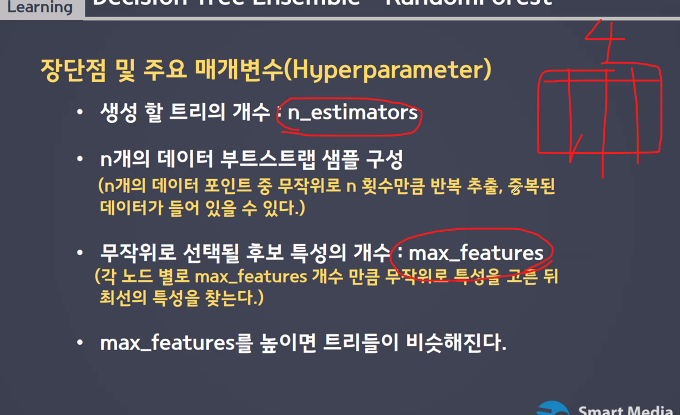

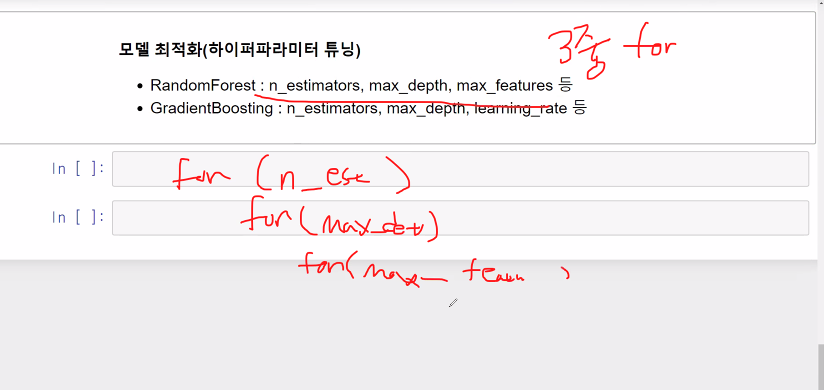

#### 모델 최적화(하이퍼파라미터 튜닝)
- RandomForest : n_estimators, max_depth, max_features 등
- GrandientBoosting : n_estimators, max_depth, learning_rate 등
- 모델의 파라미터는 서로 상호 보완 관계라서 따로 튜닝이 불가능하다.
- 여러 조합을 한 번에 묶어서 튜닝해야하기 때문에 반복문 중첩이 깊어진다.
- 이름 편하게 하기 위한 클래스를 제공하고 있다.

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
rf_model = RandomForestRegressor(random_state=1)

In [20]:
params = {
    'n_estimators' : [300,500,1000,1500],
    'max_depth' : [5,7,9,15,20],
    'max_features' : [0.3,0.4,0.5],
    'n_jobs' : [-1]
}

In [21]:
grid = GridSearchCV(rf_model,params,cv=5)

In [23]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 7, 9, 15, 20],
                         'max_features': [0.3, 0.4, 0.5],
                         'n_estimators': [300, 500, 1000, 1500],
                         'n_jobs': [-1]})

In [24]:
grid.best_params_

{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 1500, 'n_jobs': -1}

In [25]:
grid.best_score_

0.7937897205319768

In [26]:
final_rf_model=grid.best_estimator_

In [27]:
pre =final_rf_model.predict(X_test)

In [28]:
pre

array([ 726240.03545163, 1170073.20497263,  666142.60819112, ...,
       1114779.92154771,  565351.2       , 1629390.54447611])

In [29]:
mean_absolute_error(y_test, pre)

169769.27408207842